# Etapa 5: Resultados e conclusões

Após realizar o treinamento do modelo base, variações dele e com mais duas redes diferentes, iremos comparar as análises para entender qual modelo foi mais eficiente.

In [40]:
# Importnando bibliotecas

import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.image as mpimg
from IPython.display import display

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
# Definição dos caminhos
MODELS_DIR = "../models"
HISTORY_DIR = os.path.join(MODELS_DIR, "history")
CSV_DIR = "../splits"
DATA_DIR = "../data/FairFace"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Carregando conjunto de teste para utilizá-lo para avaliar os modelos treinados
print("Carregando test_split_final.csv...")
df_test = pd.read_csv(os.path.join(CSV_DIR, "test_split_final.csv"))
df_test['label'] = df_test['label'].astype(str)

Carregando test_split_final.csv...


In [42]:
# Gerador para teste
print("Criando gerador de teste...")
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=DATA_DIR,
    x_col='file',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Criando gerador de teste...
Found 407 validated image filenames belonging to 9 classes.


In [46]:
# Lista de modelos
model_info = [
    ("modelo_base", "modelo_base.keras", "modelo_base_history.pkl"),
    ("mobilenetv2_finetuned", "mobilenetv2_finetuned.keras", "finetuned_history.pkl"),
    ("mobilenetv2_dropout02", "mobilenetv2_dropout02.keras", "dropout02_history.pkl"),
    ("mobilenetv2_lr1e3", "mobilenetv2_lr1e3.keras", "lr1e3_history.pkl"),
    ("mobilenetv2_bs64", "mobilenetv2_bs64.keras", "bs64_history.pkl"),
    ("resnet50", "resnet50.keras", "resnet50_history.pkl"),
    ("efficientnetb0", "efficientnetb0.keras", "efficientnetb0_history.pkl")
]

# Para cada modelo, avaliar a acurácia e a loss.
# Essas métricas já foram calculadas nos notebooks anteriores, porém vamos recalcular para garantir que não houve erro de cálculo.

results = []
histories = {}
preds_by_model = {}

for label, model_file, history_file in model_info:
    print(f"\nAvaliando modelo: {label}")
    model_path = os.path.join(MODELS_DIR, model_file)
    history_path = os.path.join(HISTORY_DIR, history_file)

    model = load_model(model_path)
    loss, acc = model.evaluate(test_gen, verbose=0)
    results.append({
        "Modelo": label,
        "Val_Accuracy": round(acc, 4),
        "Val_Loss": round(loss, 4)
    })

    with open(history_path, "rb") as f:
        histories[label] = pickle.load(f)

    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)
    preds_by_model[label] = y_pred_classes


Avaliando modelo: modelo_base
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step

Avaliando modelo: mobilenetv2_finetuned
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step

Avaliando modelo: mobilenetv2_dropout02
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step

Avaliando modelo: mobilenetv2_lr1e3
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step

Avaliando modelo: mobilenetv2_bs64
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step

Avaliando modelo: resnet50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 424ms/step

Avaliando modelo: efficientnetb0
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step



Tabela de resultados:


,Modelo,Val_Accuracy,Val_Loss
0,mobilenetv2_finetuned,0.3686,2.7062
1,mobilenetv2_dropout02,0.3194,1.8406
2,mobilenetv2_bs64,0.2924,1.8894
3,mobilenetv2_lr1e3,0.2383,1.9906
4,modelo_base,0.2162,1.9927
5,efficientnetb0,0.0737,2.4743
6,resnet50,0.0688,3.9083


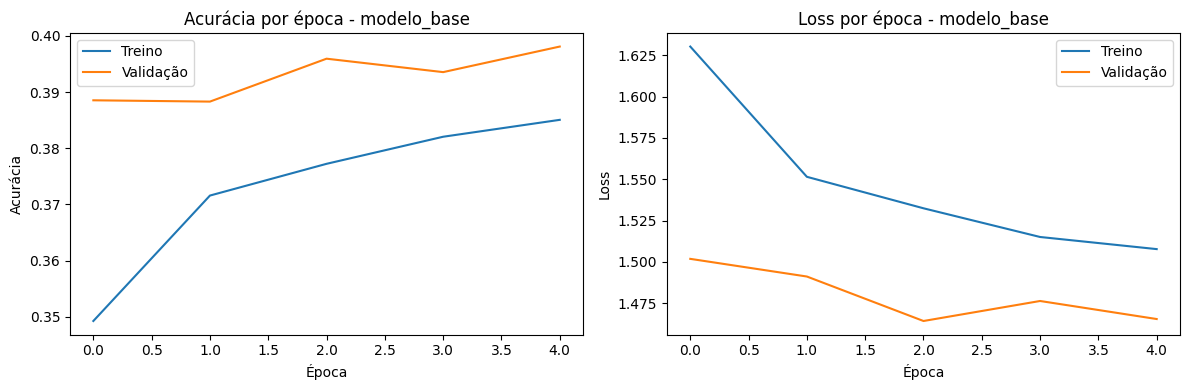

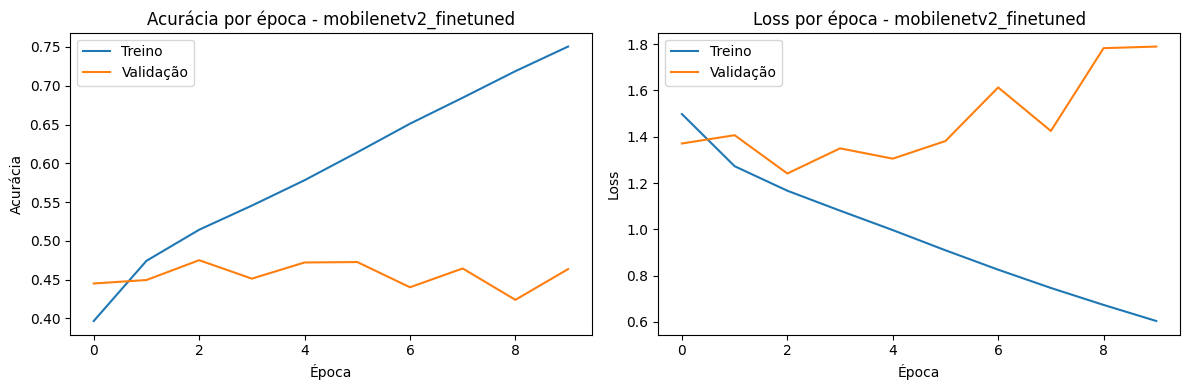

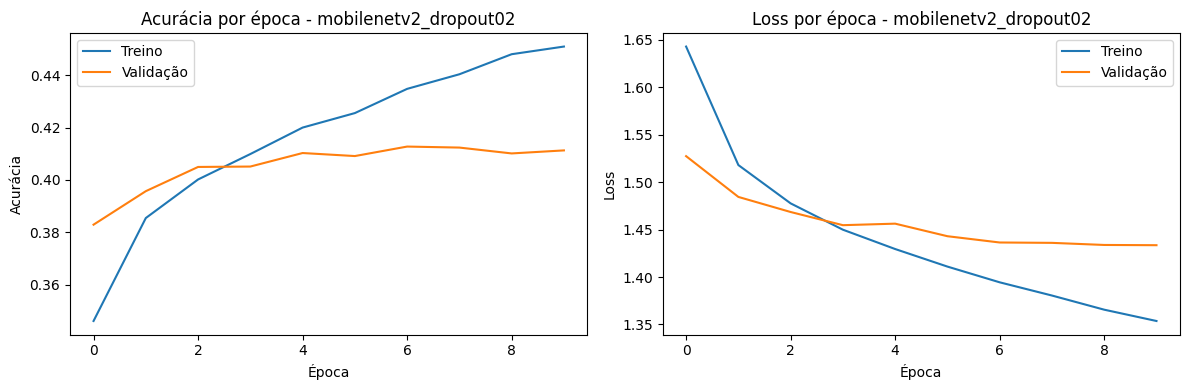

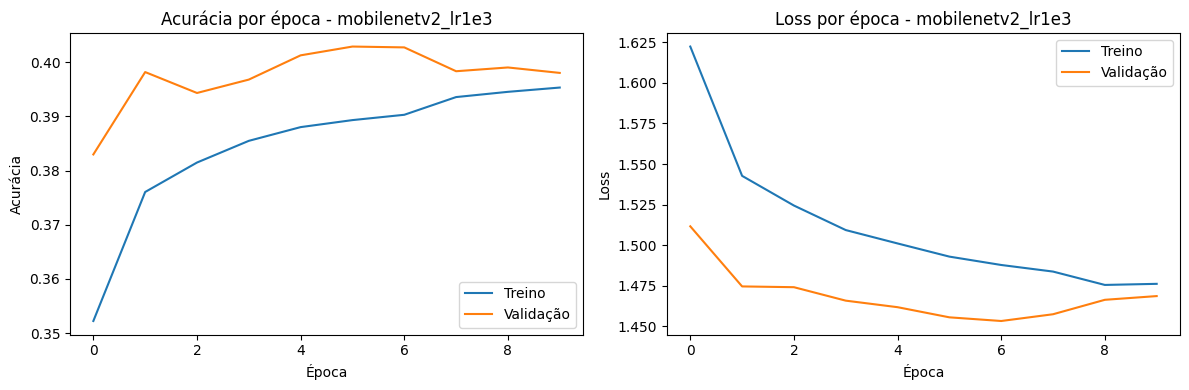

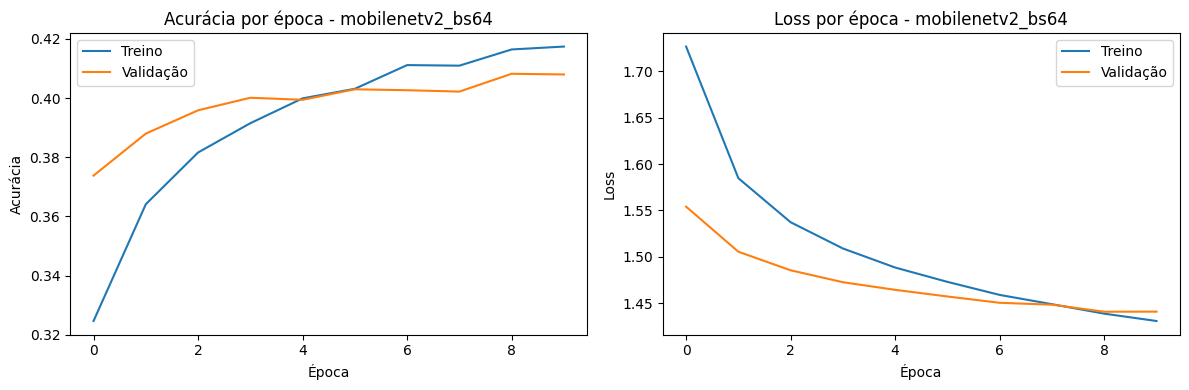

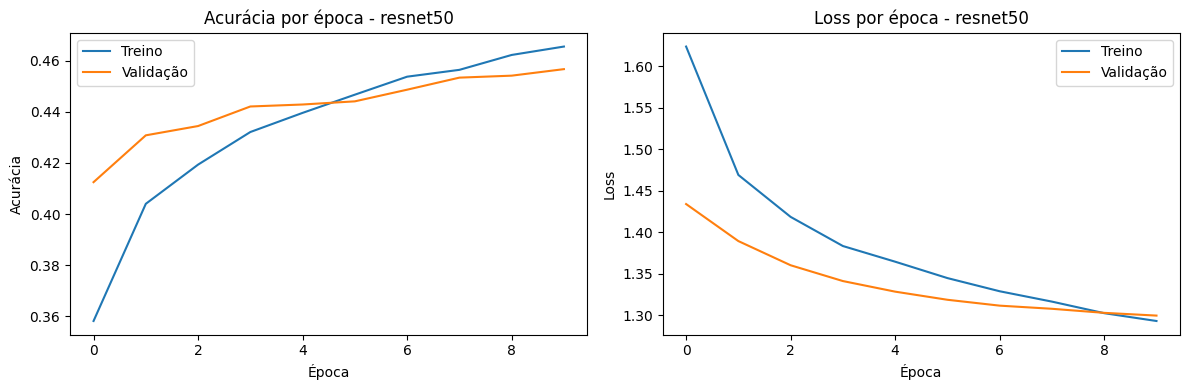

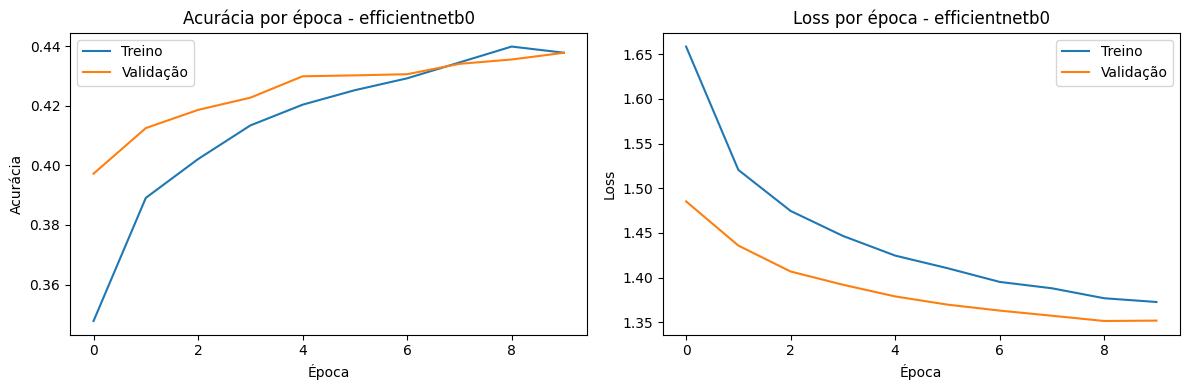

In [47]:
# Comparação final dos modelos

# Tabela comparativa: comparação de acurácia e loss de todos os modelos, para avaliar qual modelo foi o melhor
print("\nTabela de resultados:")
df_results = pd.DataFrame(results)
df_results.sort_values("Val_Accuracy", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
display(df_results)

# Gráficos de acurácia e perda por modelo para visualizar a evolução da acurácia e da loss durante o treinamento
for label, history in histories.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label='Treino')
    plt.plot(history["val_accuracy"], label='Validação')
    plt.title(f"Acurácia por época - {label}")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label='Treino')
    plt.plot(history["val_loss"], label='Validação')
    plt.title(f"Loss por época - {label}")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

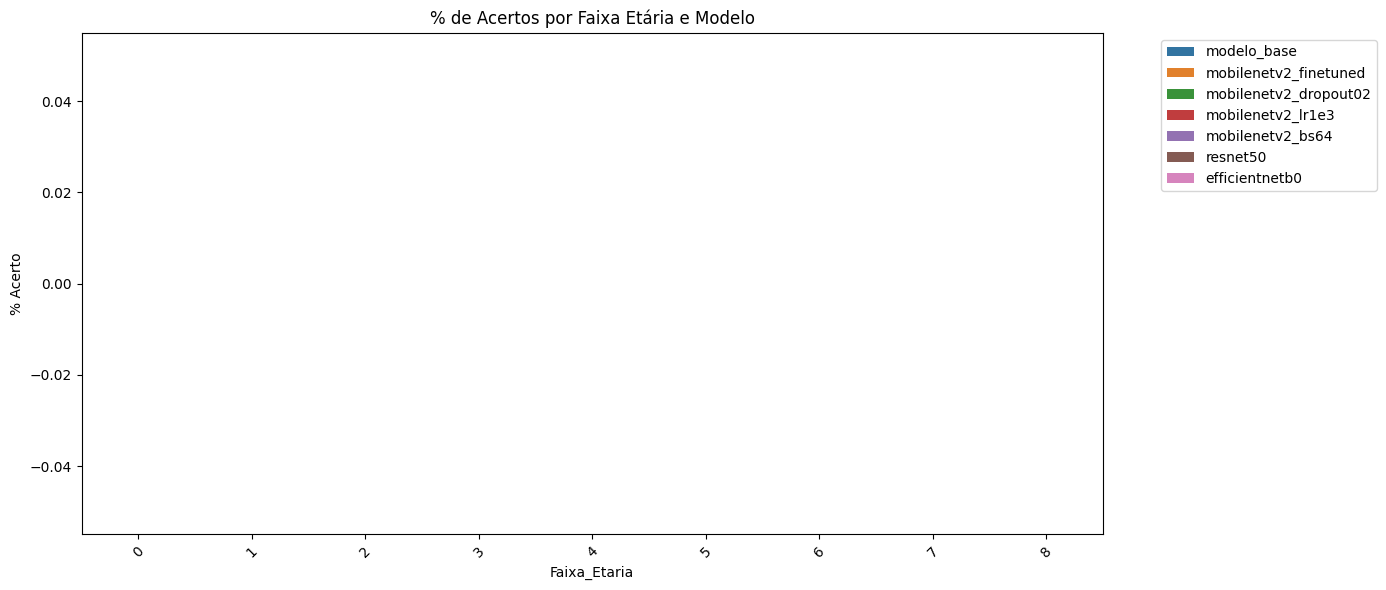

In [48]:
# Gráfico de barras empilhadas para visualizar o desempenho por classe e por modelo
plt.figure(figsize=(14, 6))
sns.barplot(data=df_por_classe, x="Faixa_Etaria", y="% Acerto", hue="Modelo")
plt.title("% de Acertos por Faixa Etária e Modelo")
plt.ylabel("% Acerto")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Avaliar melhor modelo por robustez, não apenas acurácia
# Critério: menor diferença treino/validação, acurácia alta, curvas estáveis
avaliacoes = []
for label, hist in histories.items():
    acc_gap = abs(hist["accuracy"][-1] - hist["val_accuracy"][-1])
    val_acc = hist["val_accuracy"][-1]
    val_loss = hist["val_loss"][-1]
    avaliacoes.append({"Modelo": label, "Gap_Treino_Val": acc_gap, "Val_Accuracy": val_acc, "Val_Loss": val_loss})

avaliacoes_df = pd.DataFrame(avaliacoes)
avaliacoes_df = avaliacoes_df.sort_values(by=["Gap_Treino_Val", "Val_Loss"], ascending=[True, True])
best_model_name = avaliacoes_df.iloc[0]["Modelo"]
print(f"\n🏆 Melhor modelo por robustez + acurácia equilibrada: {best_model_name}")

In [ ]:
# Avaliação do melhor modelo com métricas por classe
y_pred = load_model(os.path.join(MODELS_DIR, best_model_name + ".keras")).predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title(f"Matriz de Confusão - {best_model_name}")
plt.show()

In [ ]:
# Relatório de classificação (inclui F1-score, precision, recall)
report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report[["precision", "recall", "f1-score", "support"]])

In [ ]:
# Exemplo visual de acertos e erros
# Mostrar exemplos de acertos e erros por cada faixa etária
filenames = test_gen.filenames
indices = np.random.choice(len(filenames), size=12, replace=False)

plt.figure(figsize=(12, 10))
for i, idx in enumerate(indices):
    img_path = os.path.join(DATA_DIR, filenames[idx])
    img = mpimg.imread(img_path)
    true_label = class_labels[y_true[idx]]
    pred_label = class_labels[y_pred_classes[idx]]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Verdadeiro: {true_label}\nPrevisto: {pred_label}", color=color)
    plt.axis("off")

plt.suptitle("Exemplos de previsões (verde = correto, vermelho = erro)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Conclusão final
print("\n🧠 Conclusão:")
print(f"Após comparar todos os modelos em termos de acurácia, perda e equilíbrio entre treino e validação, o modelo '{best_model_name}' se destacou. Embora outros modelos tenham alcançado acurácias mais altas pontualmente, esse modelo apresentou a melhor combinação de desempenho geral, estabilidade de curva e baixa diferença entre acurácia de treino e validação. Isso significa que ele tem menor risco de overfitting e maior chance de generalizar bem para novos dados.")

